<a href="https://colab.research.google.com/github/ChiomaO15/ChiomaO15/blob/main/B_COAGULANS_PREDICTION_MODEL_FOR_UNANNOTATED_GENES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 24.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
from Bio import SeqIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE

In [3]:
# Step 1: Parse the FASTA file
fasta_file = "/content/B.coagulans contigs (1).fasta"
fasta_data = {}

print("Parsing FASTA file...")
for record in SeqIO.parse(fasta_file, "fasta"):
    fasta_data[record.id] = str(record.seq)

Parsing FASTA file...


In [4]:
# Normalize FASTA gene IDs
normalized_fasta_data = fasta_data  # We already normalized by stripping and converting to lowercase

In [6]:
# Step 2: Load the annotation file
annotation_file = "/content/b.coagulans converted_file annotation.csv"
annotations_df = pd.read_csv(annotation_file)
annotations_df['Gene ID'] = annotations_df['Gene ID'].str.strip()  # Clean up whitespace

print("Annotations file loaded. First few rows:")
print(annotations_df.head())

Annotations file loaded. First few rows:
                            Gene ID Unnamed: 1  Start position  End position  \
0  NODE_143_length_593_cov_1.577519      KBase             469           591   
1  NODE_143_length_593_cov_1.577519      KBase             469           591   
2  NODE_143_length_593_cov_1.577519      KBase             469           591   
3  NODE_143_length_593_cov_1.577519      KBase             469           591   
4  NODE_149_length_577_cov_1.480000      KBase              74           577   

  Unnamed: 4 Unnamed: 5  Unnamed: 6  \
0          .          +           0   
1          .          +           0   
2          .          +           0   
3          .          +           0   
4          .          -           0   

                                             Product  
0  ID=B.coagulansannotation.CDS.4123; product=his...  
1  ID=B.coagulansannotation.CDS.4123_mRNA; Parent...  
2  ID=B.coagulansannotation.CDS.4123_mRNA_exon_1;...  
3  ID=B.coagulansannota

In [7]:
# Step 3: Merge FASTA sequences with annotations
print("Merging FASTA data with annotations...")
merged_data = []

for gene_id, sequence in fasta_data.items():
    if gene_id in annotations_df['Gene ID'].values:
        product = annotations_df[annotations_df['Gene ID'] == gene_id]['Product'].values[0]
    else:
        product = "unknown"  # Label unannotated genes
    merged_data.append({'gene_id': gene_id, 'sequence': sequence, 'product': product})

merged_df = pd.DataFrame(merged_data)

print("Merged data:")
print(merged_df.head())

Merging FASTA data with annotations...
Merged data:
                              gene_id  \
0  NODE_1_length_305840_cov_54.575743   
1  NODE_2_length_206030_cov_81.750477   
2  NODE_3_length_197640_cov_68.108325   
3  NODE_4_length_159190_cov_58.526211   
4  NODE_5_length_141351_cov_63.667257   

                                            sequence  \
0  AAAAATTTTCTAAATGTGGATAAGTCATTTTATCATAAAACATCTA...   
1  CCCGCGGAAAGCGAGTGAATTTCGCGCGCCTCAACATCCCCGTTAT...   
2  CTTGTATTCGACTTGTCACTAAGCCATGCCAAAATATTCGTCCAGC...   
3  ATCAACAAAAAATAAGGCTCTTACCCGATAATATTGATTCACAAGC...   
4  TAAATTATTACATATTTGGCCGCTTTTTTGGGAGGTATATTTAAAT...   

                                             product  
0                     ID=B.coagulansannotation.CDS.1  
1  ID=B.coagulansannotation.repeat.2; product=rep...  
2  ID=B.coagulansannotation.repeat.4; product=rep...  
3                   ID=B.coagulansannotation.CDS.823  
4  ID=B.coagulansannotation.CDS.1023; product=UPF...  


In [9]:
# Merge data with cleaned product names
merged_data = []
for gene_id, sequence in normalized_fasta_data.items():
    if gene_id in annotations_df['Gene ID'].values:
        full_product = annotations_df[annotations_df['Gene ID'] == gene_id]['Product'].values[0]
        # Extract product name after "product="
        if "product=" in full_product:
            product = full_product.split("product=")[-1].split(";")[0].strip()
        else:
            product = "unknown"
    else:
        product = "unknown"
    merged_data.append({'gene_id': gene_id, 'sequence': sequence, 'product': product})

In [10]:
merged_df = pd.DataFrame(merged_data)

print("Merged data:")
print(merged_df.head())


Merged data:
                              gene_id  \
0  NODE_1_length_305840_cov_54.575743   
1  NODE_2_length_206030_cov_81.750477   
2  NODE_3_length_197640_cov_68.108325   
3  NODE_4_length_159190_cov_58.526211   
4  NODE_5_length_141351_cov_63.667257   

                                            sequence  \
0  AAAAATTTTCTAAATGTGGATAAGTCATTTTATCATAAAACATCTA...   
1  CCCGCGGAAAGCGAGTGAATTTCGCGCGCCTCAACATCCCCGTTAT...   
2  CTTGTATTCGACTTGTCACTAAGCCATGCCAAAATATTCGTCCAGC...   
3  ATCAACAAAAAATAAGGCTCTTACCCGATAATATTGATTCACAAGC...   
4  TAAATTATTACATATTTGGCCGCTTTTTTGGGAGGTATATTTAAAT...   

                         product  
0                        unknown  
1                  repeat region  
2                  repeat region  
3                        unknown  
4  UPF0118 membrane protein YrrI  


In [11]:
# Step 4: Separate Annotated and Unannotated Genes
annotated_data = merged_df[merged_df['product'] != "unknown"]
unannotated_data = merged_df[merged_df['product'] == "unknown"]


In [12]:
print(f"Number of annotated genes: {len(annotated_data)}")
print(f"Number of unannotated genes: {len(unannotated_data)}")


Number of annotated genes: 150
Number of unannotated genes: 1899


In [13]:
# Save merged data for reference
merged_df.to_csv("/content/merged_fasta_with_annotations.csv", index=False)
print("Merged data saved to /content/merged_fasta_with_annotations.csv")

Merged data saved to /content/merged_fasta_with_annotations.csv


In [14]:
# Step 5: Feature extraction (GC Content and K-mers)
def calculate_gc_content(sequence):
    """Calculate GC content of a sequence."""
    g_count = sequence.count("G")
    c_count = sequence.count("C")
    return (g_count + c_count) / len(sequence) * 100

def extract_kmers(sequence, k=3):
    """Extract k-mer frequencies."""
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    return Counter(kmers)

def extract_features(data, k=3):
    """Extract GC content and k-mer frequencies for each gene."""
    features = []
    for _, row in data.iterrows():
        sequence = row['sequence']
        gc_content = calculate_gc_content(sequence)
        kmer_freqs = extract_kmers(sequence, k)
        feature_vector = [gc_content] + list(kmer_freqs.values())
        features.append(feature_vector)
    return pd.DataFrame(features)

In [15]:
print("Extracting features for annotated genes...")
X_annotated = extract_features(annotated_data)
y_annotated = annotated_data['product']

Extracting features for annotated genes...


In [16]:
# Step 6: Train Random Forest model
print("Training Random Forest model...")
X_train, X_test, y_train, y_test = train_test_split(X_annotated, y_annotated, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100,class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)

Training Random Forest model...


RandomForestClassifier(class_weight='balanced', random_state=42)

In [17]:
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
                                                                                                                                                                   precision    recall  f1-score   support

                                                                              1%2C4-alpha-glucan %28glycogen%29 branching enzyme%2C GH-13-type %28EC 2.4.1.18%29       0.00      0.00      0.00         1
                                                                                                                    6-phospho-beta-glucosidase %28EC 3.2.1.86%29       0.00      0.00      0.00         1
                                                                           Acetaldehyde dehydrogenase %28EC 1.2.1.10%29%3BAlcohol dehydrogenase %28EC 1.1.1.1%29       0.00      0.00      0.00         0
                                                                                                                     Aspartate aminotransferase %28EC 2.6.1.1%29       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [18]:
# Step 7: Extract features for unannotated genes
print("Extracting features for unannotated genes...")
X_unannotated = extract_features(unannotated_data)

Extracting features for unannotated genes...


In [19]:
# Step 8: Predict functions for unannotated genes
print("Predicting functions for unannotated genes...")
predicted_products = rf_model.predict(X_unannotated)
unannotated_data['predicted_product'] = predicted_products


Predicting functions for unannotated genes...


<ipython-input-19-68e43f1bf714>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unannotated_data['predicted_product'] = predicted_products


In [20]:
# Save the results
output_file = "/content/predicted_unannotated_genes.csv"
unannotated_data.to_csv(output_file, index=False)
print(f"Predicted results saved to {output_file}")


Predicted results saved to /content/predicted_unannotated_genes.csv


In [21]:
# Display a preview of the predicted results
print("Predicted functions for unannotated genes:")
print(unannotated_data[['gene_id', 'predicted_product']].head())

Predicted functions for unannotated genes:
                               gene_id            predicted_product
0   NODE_1_length_305840_cov_54.575743                repeat region
3   NODE_4_length_159190_cov_58.526211                repeat region
8   NODE_9_length_101880_cov_76.784014  Sulfur carrier protein FdhD
10  NODE_11_length_96253_cov_88.339149                repeat region
11  NODE_12_length_87537_cov_84.544112                repeat region


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-28-07ffc9c75148>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.values, y=product_counts.index, palette="viridis")


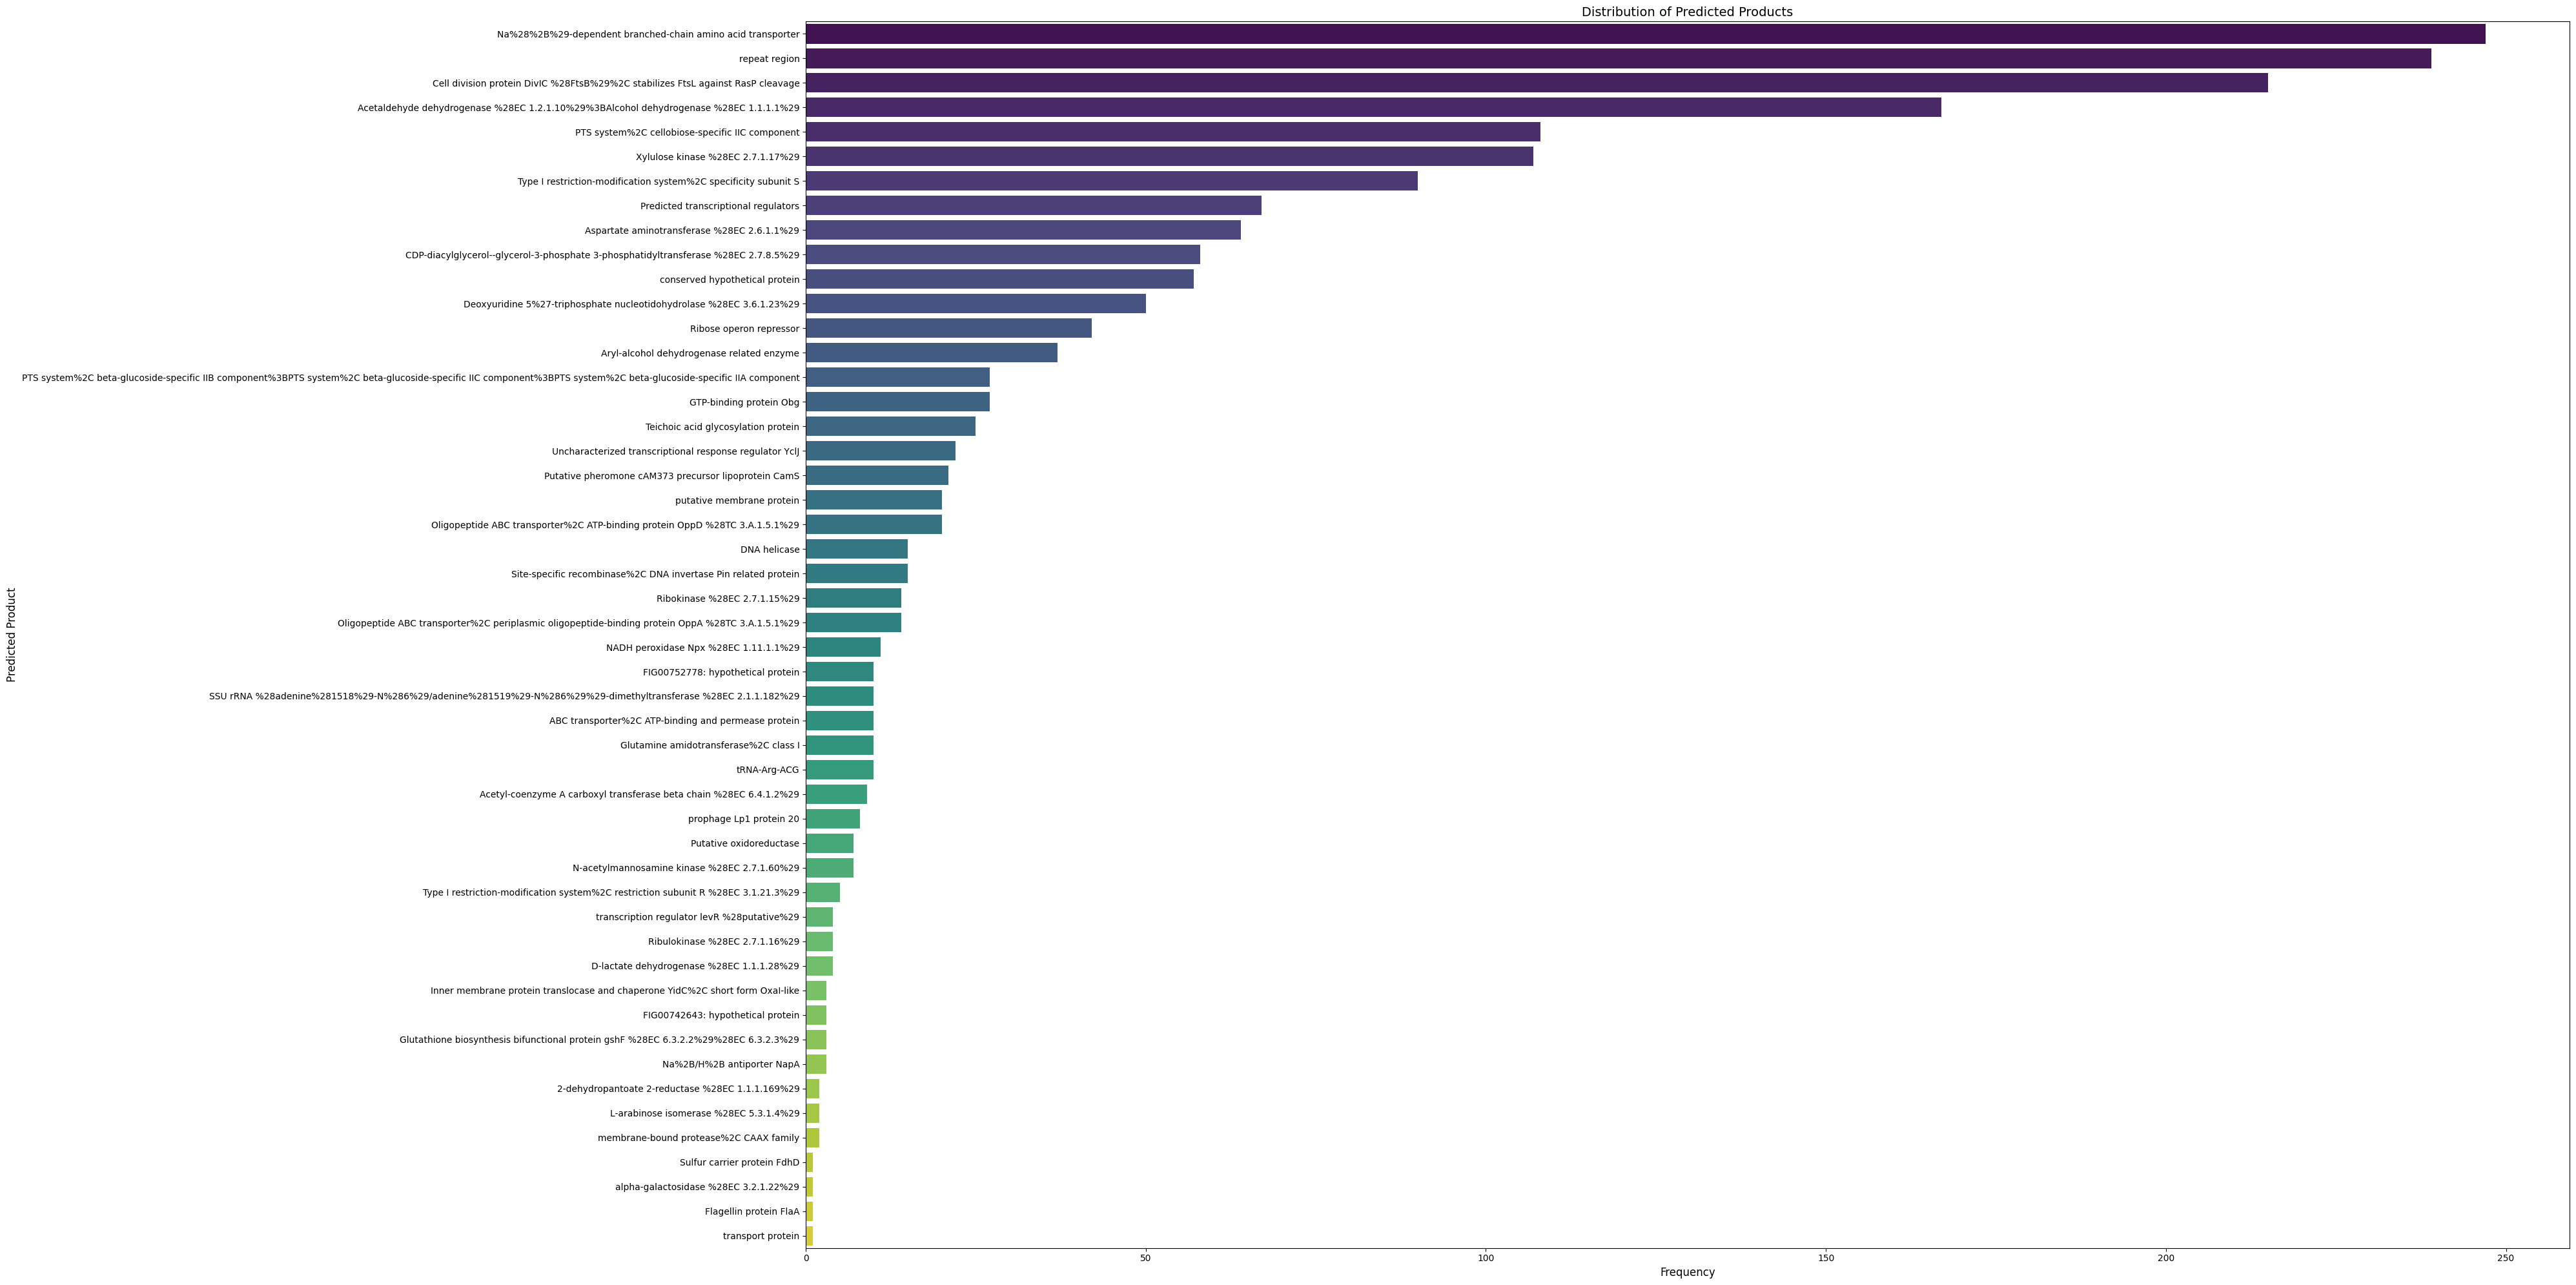

In [28]:
# Count the frequency of each predicted product
product_counts = unannotated_data['predicted_product'].value_counts()

# Create a bar plot
plt.figure(figsize=(40, 20))
sns.barplot(x=product_counts.values, y=product_counts.index, palette="viridis")
plt.title("Distribution of Predicted Products", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Predicted Product", fontsize=12)
plt.tight_layout()
plt.show()


<ipython-input-24-a07d3fad7ce5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unannotated_data['sequence_length'] = unannotated_data['sequence'].apply(len)
<ipython-input-24-a07d3fad7ce5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unannotated_data['gc_content'] = unannotated_data['sequence'].apply(calculate_gc_content)
<ipython-input-24-a07d3fad7ce5>:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_lay

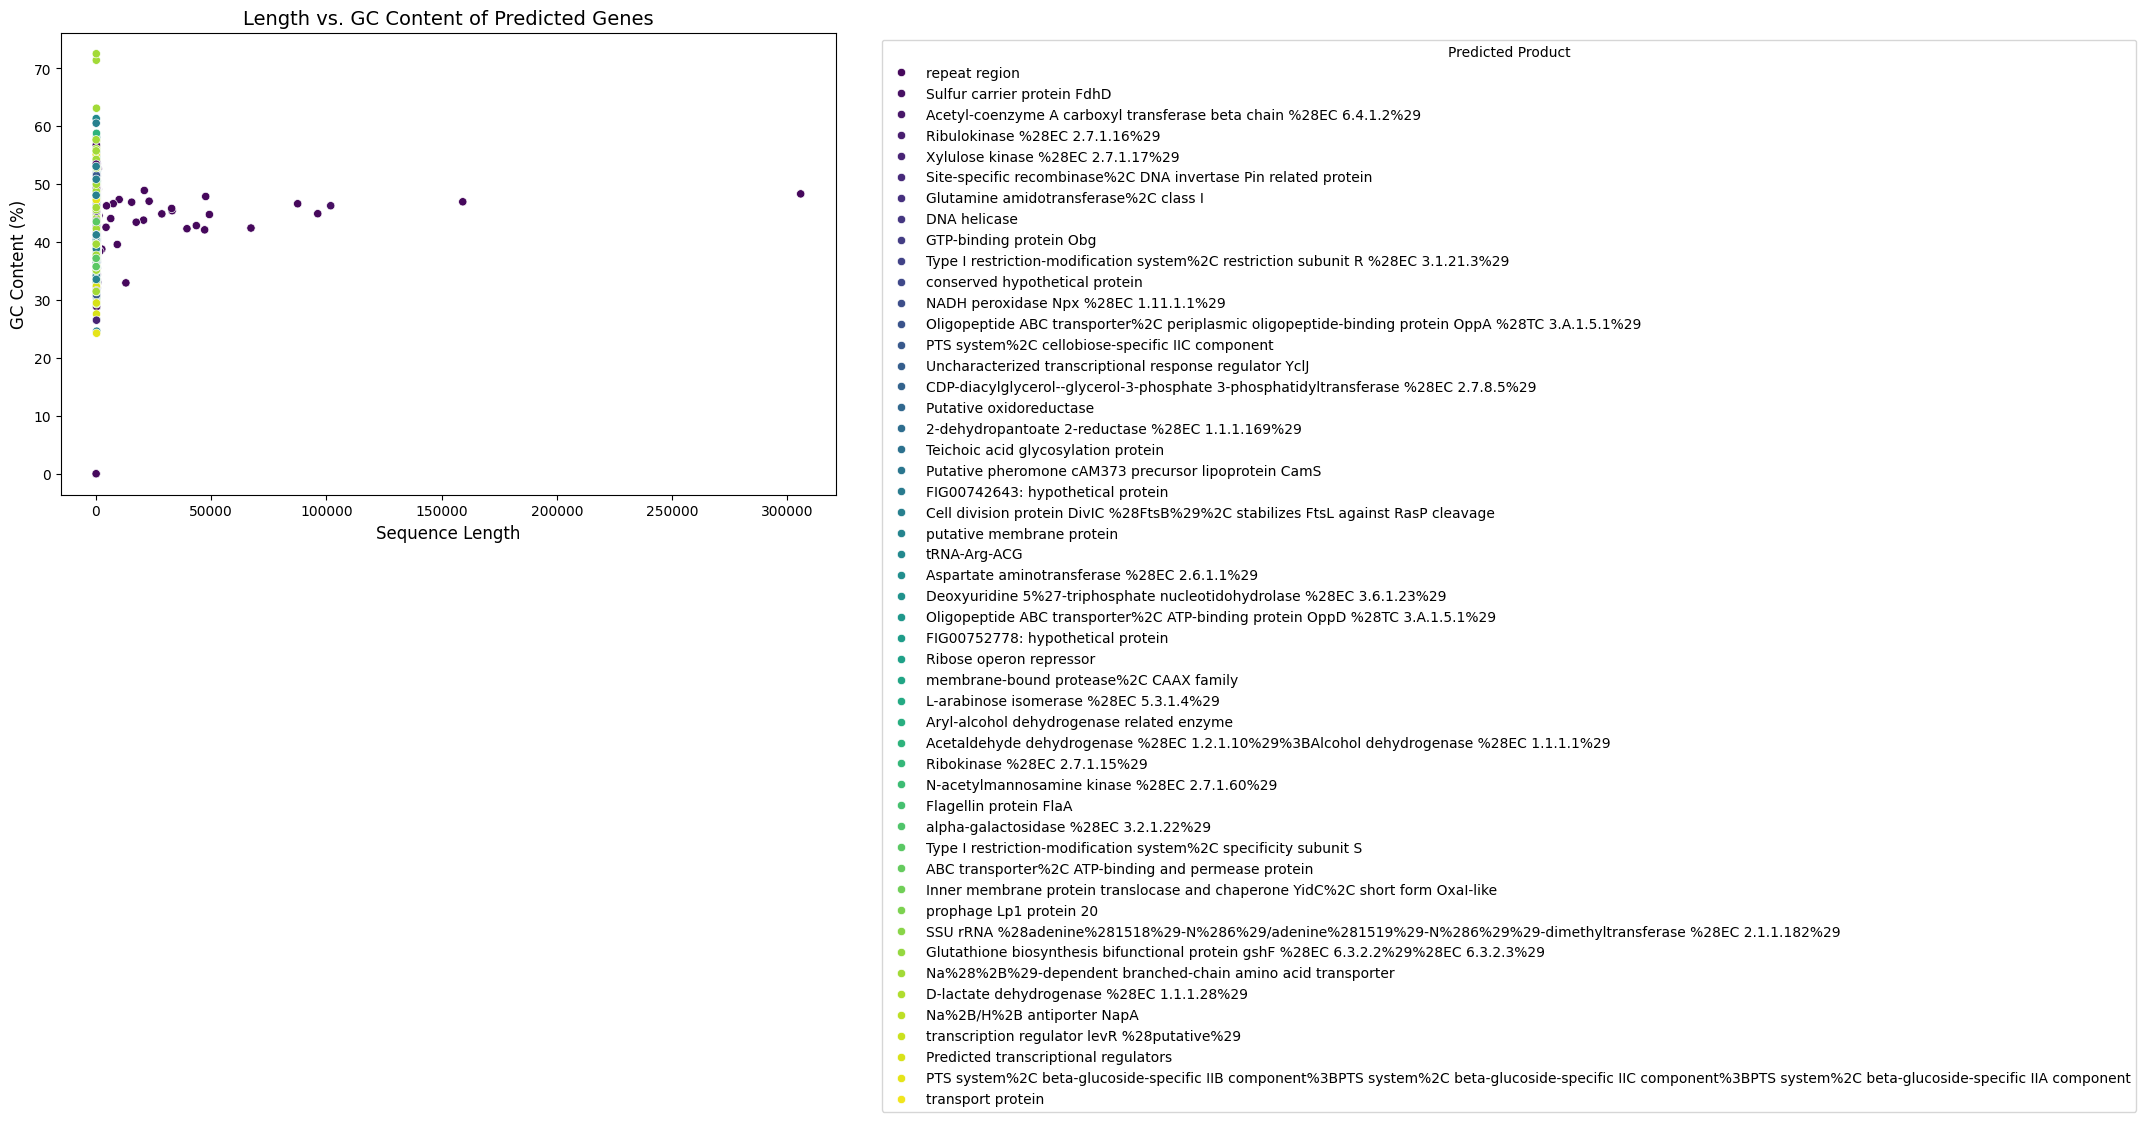

In [24]:
# Extract length and GC content for visualization
unannotated_data['sequence_length'] = unannotated_data['sequence'].apply(len)
unannotated_data['gc_content'] = unannotated_data['sequence'].apply(calculate_gc_content)

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=unannotated_data, x='sequence_length', y='gc_content', hue='predicted_product', palette='viridis')
plt.title("Length vs. GC Content of Predicted Genes", fontsize=14)
plt.xlabel("Sequence Length", fontsize=12)
plt.ylabel("GC Content (%)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Predicted Product")
plt.tight_layout()
plt.show()